## **Moving Average Convergence/Divergence (MACD)** using the Python TA Library
* Is a trend following momentum indicator i.e. it looks at an asset's momentum to determine if its up or down
* Consists of two moving averages and an histogram
* If the 2 moving averages are moving closer together it is said to be *converging* and if they are moving away from each other it is said to be *diverging*
* The difference of the lines is represented by the histogram
* **Crossovers**: buy signals occur when the more reactive line (MACD) line crosses the slower/less reactive line (signal) and sell signals occur when the MACD line crosses below the signal 
* **Histogram reversals**: When the market price is moving strongly in a direction, the histogram will increase in height, and when the histogram shrinks, it is a sign the market is moving slower 
* **Zero crosses** if MACD line crosses the zero line from below an uptrend might be emerging and if it crosses from above then a downtrend could be emerging
*Source: https://www.ig.com/uk/trading-strategies/macd-trading-strategy-190610#:~:text=The%20strategy%20is%20to%20buy,the%20signals%20issued%20too%20late.*

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import ta

In [64]:
# Read the file in from device
# Data was aquired from: https://in.finance.yahoo.com/quote/BTC-INR/history/
date_cols = ['Date']
# df = pd.read_csv('BTC_INR_2years_10Nov2020.csv', parse_dates=date_cols, index_col=['Date'])
df = pd.read_csv('BTC_INR.csv', parse_dates=date_cols, index_col=['Date'])

In [65]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-19,597513.6875,604244.375,582071.4375,589701.81250,589701.81250,1515089488093
2019-11-20,589519.8125,591254.250,574980.1250,576182.87500,576182.87500,1490424109615
2019-11-21,575922.7500,581903.625,545115.9375,548371.12500,548371.12500,1615408241538
2019-11-22,548429.9375,552615.125,498004.1875,523840.28125,523840.28125,2458344880212
2019-11-23,523810.6250,534299.125,513418.8750,531107.06250,531107.06250,1508285307150


In [66]:
# There is 1 day of missing values. Using linear interpolate to fill that value
df = df.interpolate()

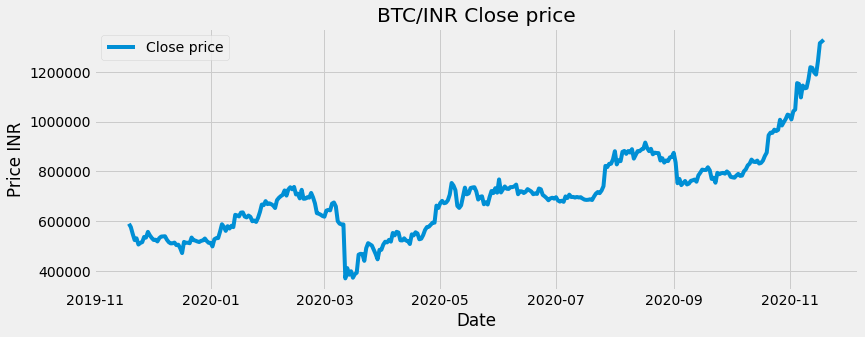

In [67]:
# Visualise
plt.figure(figsize=(12.2,4.5))
plt.plot(df['Close'], label='Close price')
plt.legend(loc='upper left')
plt.title('BTC/INR Close price')
plt.xlabel('Date')
plt.ylabel('Price INR')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [68]:
macd_indicator = ta.trend.MACD(df['Close'], n_slow = 26, n_fast = 12, n_sign = 9, fillna = False )
df['MACD'] = macd_indicator.macd()
df['Diff'] = macd_indicator.macd_diff()
df['Signal'] = macd_indicator.macd_signal()

In [69]:
def get_buy_sell_signal(dataframe):
    buy = []
    sell = []
    flag = -1 # Tells us if the price continues to rise or decreases - flag changes when the two lines cross again

    for row in dataframe.itertuples():
        if (row.MACD > row.Signal) and (row.MACD < 0): # MACD has crossed the signal line & is below the zero line
            sell.append(np.nan)
            if flag != 1: # We have not been here before
                buy.append(row.Close)
                flag = 1 # We have been here
            else:
                buy.append(np.nan)
        
        elif (row.MACD < row.Signal) and (row.MACD > 0): # Signal line has crossed the MACD line
            buy.append(np.nan)
            if flag != 0: # We have not been here before but different value than previous
                sell.append(row.Close)
                flag = 0 # We have been here - change flag to 0
            else:
                sell.append(np.nan)
        else:
            sell.append(np.nan)
            buy.append(np.nan)
    
    return (buy, sell)

In [70]:
df['Buy_Signal_Price']= get_buy_sell_signal(df)[0]
df['Sell_Signal_Price'] = get_buy_sell_signal(df)[1]

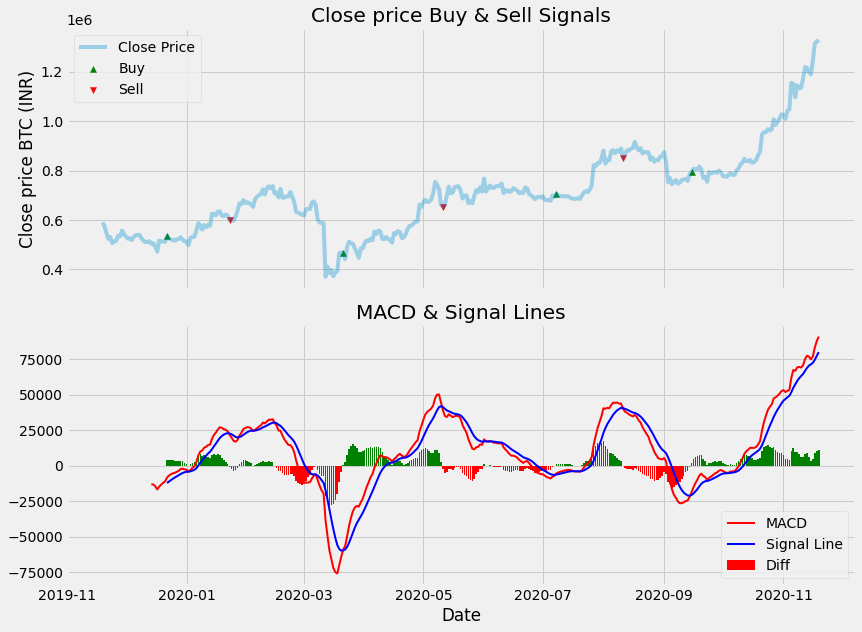

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12.2, 9))

ax1.scatter(df.index, df['Buy_Signal_Price'], color='green', label='Buy', marker = '^', alpha =1)
ax1.scatter(df.index, df['Sell_Signal_Price'], color='red', label='Sell', marker = 'v', alpha =1)
ax1.plot(df['Close'], label = 'Close Price', alpha = 0.35)
ax1.set_title('Close price Buy & Sell Signals')
ax1.set_ylabel('Close price BTC (INR)')
ax1.legend(loc='upper left')

ax2.set_title('MACD & Signal Lines')
ax2.plot(df.index, df['MACD'], label = 'MACD', color = 'red', linewidth = 2)
ax2.plot(df.index, df['Signal'], label = 'Signal Line', color = 'blue', linewidth = 2)
ax2.bar(df.index, df['Diff'], label = 'Diff', color=(df['Diff'] > 0).map({True: 'g', False: 'r'}))
ax2.set_xlabel('Date')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [72]:
buy_signal_entries = df[df.Buy_Signal_Price.notna()].copy()
sell_signal_entries = df[df.Sell_Signal_Price.notna()].copy()

In [73]:
def get_buy_sell_pairs(buys_df, sells_df):
    ''' Takes a buy dataframe (buys_df) & and sell dataframe (sells_df)
        and returns buy/sell pairs such that the buy date is before the 
        sell date.    
    '''
    pairs = []
    date_set = set()

    for buy_date, buy_row in buys_df.iterrows():
        for sell_date, sell_row in sells_df.iterrows():
            if (buy_date.date() not in date_set) and (sell_date.date() not in date_set) and (buy_date.date() < sell_date.date()):
                pairs.append((buy_row['Buy_Signal_Price'], sell_row['Sell_Signal_Price']))
                date_set.add(buy_date.date())
                date_set.add(sell_date.date())
    return pairs

In [74]:
buy_sell_pairs = get_buy_sell_pairs(buy_signal_entries, sell_signal_entries)
buy_sell_pairs

[(534074.4375, 599645.0625), (467730.8125, 653199.75), (706560.625, 851413.5)]

In [75]:
def get_trade_value(buy_price, sell_price, stake):
    ''' Calculates the profit/loss of a sale given 
        the purchase price of an asset (buy_price), 
        the sales price of the asset (sell_price) &
        and the amount invested in the asset'''
    BTC_one_INR = 1/buy_price
    amount_purchased = BTC_one_INR * stake
    sales_value = amount_purchased * sell_price
    return round(sales_value - stake,2)

In [76]:
# Get the profit/loss of executing the buy-sell for 
stake_bid = 10000 
sale_values = [get_trade_value(b,s,stake_bid) for b,s in buy_sell_pairs]
sale_values

[1227.74, 3965.29, 2050.11]

In [77]:
print(f'We would have made INR {round(np.sum(sale_values),2)} by following MACD strategy and staking INR {stake_bid:,} each on {len(sale_values)} trades over a period of a {(df.index[-1]-df.index[0]).days} days.\nThis would have yielded a ROI of {round(np.sum(sale_values)/(stake_bid* len(sale_values))*100,2)}%.\nThis does not take into account exchange fees')

We would have made INR 7243.14 by following MACD strategy and staking INR 10,000 each on 3 trades over a period of a 366 days.
This would have yielded a ROI of 24.14%.
This does not take into account exchange fees
